In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll

In [2]:
def sample_batch(batch_size, device='cpu'):
    data, _ = make_swiss_roll(batch_size)
    data = data[:, [2, 0]] / 10
    data = data * np.array([1, -1])
    return torch.from_numpy(data).to(device)

We have 2 approaches for the reverse diffusion process - 
1. We can create a neural network for each time step and use it to predict the mu, std for that time step.
2. We can encode the time step to a high dimensional space, then concatenate that information with the image data and pass it to a single NN to predict the mu and std for that time step.

We are following the first approach in this notebook. Now, for this first approach, we can improve our training speed by creating a base NN that learns some hidden state h from the data. Then for each timestep t, we can create a small NN that can predict the mu, std from the hidden state h. This improves speed since we're not using a huge NN for each time step.

In [3]:
class MLP(nn.Module):
    
    def __init__(self, N=40, data_dim=2, hidden_dim=64):
        super().__init__()
        self.network_head = nn.Sequential(
            nn.Linear(data_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.network_tail = nn.ModuleList([nn.Sequential(nn.Linear(hidden_dim, hidden_dim),
                                           nn.ReLU(),
                                           nn.Linear(hidden_dim, data_dim * 2),) for t in range(N)])
        
    def forward(self, x, t):
        h = self.network_head(x)        # [batch_size, hidden_dim]
        tmp = self.network_tail[t](h)   # [batch_size, data_dim * 2]
        mu, h = torch.chunk(tmp, 2, dim=1)  # mu is the mean, h is variance. 
        # Since variance needs to be greater than zero, we apply exp function.
        var = torch.exp(h)  # Making variance greater than zero
        std = torch.sqrt(var)
        
        return mu, std

In [4]:
model = MLP()
t = 5
x = torch.randn((64, 2))
mu, std = model(x, t)
print(mu.shape)
print(std.shape)

torch.Size([64, 2])
torch.Size([64, 2])


In [12]:
class DiffusionModel():
    
    def __init__(self, T, model: nn.Module, dim=2):
        # 3e-1 --> 0.3, 1e-5 --> 0.00001
        self.betas = torch.sigmoid(torch.linspace(-18, 10, T)) * (3e-1 - 1e-5) + 1e-5
        self.alphas = 1 - self.betas
        self.alphas_bar = torch.cumprod(self.alphas, dim=0)
        
        self.T = T
        self.model = model
        self.dim = dim
        
    def forward_diffusion(self, x0, t):
        assert t>0, 't should be greater than 0'
        assert t<=self.T, f't should be lower or equal than total time steps T = {self.T}'
        t = t-1
        mu = torch.sqrt(self.alphas_bar[t]) * x0
        std = torch.sqrt(1 - self.alphas_bar[t])
        epsilon = torch.randn_like(x0)
        return mu, std, mu + std * epsilon
    
    def reverse_diffusion(self, xt, t):
        assert t>0, 't should be greater than 0'
        assert t<=self.T, f't should be lower or equal than total time steps T = {self.T}'
        t = t-1
        mu, std = self.model(xt, t)
        epsilon = torch.randn_like(xt)
        return mu + std * epsilon
    
    def sample(self, batch_size):
        noise = torch.randn((batch_size, self.dim))
        x = noise
        
        samples = [x]
        for t in range(self.T, 0, -1):
            if not (t==1):
                x = self.reverse_diffusion(x, t)
                
            samples.append(x)
            
        return samples[::-1]    # Inverting it so that at t=40, we get the reformed img and not noise (bcz reverse diff).    
    
    def get_loss(self, x0):
        """
        :param x0: batch [batch_size, self.dim]
        """
        
        t = torch.randint(2, 40+1, 1)   # Getting a random integer between 1, 40.
        mu_tmp, sigma_tmp, xt = self.forward_diffusion(x0, t)
        mu_p, sigma_p, xt_minus1 = self.reverse_diffusion(xt, t)
        
        mu_q = torch.sqrt(((1-self.alphas_bar[t-1]) / (1-self.alphas_bar[t])) * self.betas[t])
        sigma_q = 
        
        KL = torch.log(sigma_p) - torch.log(sigma_q) + (sigma_q**2 + (mu_q - mu_p)**2) / (2*sigma_p**2) - 1/2
        K = -torch.mean(KL) # Should be maximized
        loss = -K # Should be minimized

In [13]:
x0 = sample_batch(3000)
mlp_model =  MLP()
model = DiffusionModel(40, mlp_model)
xT = model.forward_diffusion(x0, 40)

In [14]:
print(f'mean: {xT.mean().item():.5f}')
print(f'std: {xT.std().item():.5f}')

mean: -0.09668
std: 0.69885


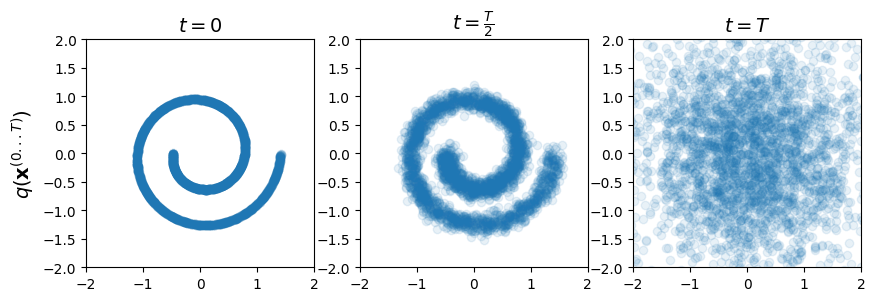

In [15]:
fontsize = 14
fig = plt.figure(figsize=(10, 6))

N = 5_000
x0 = sample_batch(N)
samples = model.sample(N)

data = [x0, model.forward_diffusion(x0, 20), model.forward_diffusion(x0, 40)]
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.scatter(data[i][:, 0], data[i][:, 1], alpha=0.1, s=1)
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal') # Setting the aspect ratio to be equal for all 3 subplots.
    
    if i==0:
        plt.title('$t=0$', fontsize=fontsize)
        plt.ylabel(r'$q(\mathbf{x}^{(0...T)})$', fontsize=fontsize)
    if i==1: plt.title(r'$t=\frac{T}{2}$', fontsize=fontsize)
    if i==2: plt.title('$t=T$', fontsize=fontsize)
    
time_steps = [0, 20, 40]
for i in range(3):
    plt.subplot(2, 3, 4+i)
    plt.scatter(samples[time_steps[i]][:, 0], samples[time_steps[i]][:, 1], alpha=0.1, s=1, c='r')
    plt.xlim([-2, 2])
    plt.ylim([-2, 2])
    plt.gca().set_aspect('equal')
    
    if i==0: plt.ylabel(r'$p(\mathbf{x}^{(0...T)})$', fontsize=fontsize)

plt.savefig('forward_process.png', bbox_inches='tight')
plt.show()